In [1]:
%load_ext autoreload
%autoreload 2

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from hyperopt import hp, tpe, fmin, Trials
from tqdm import tqdm
# from tqdm.notebook import tqdm

from collections import OrderedDict, defaultdict
import itertools
from functools import partial
import datetime
from joblib import Parallel, delayed
import copy
import json

from data.dataloader import get_jhu_data, get_covid19india_api_data, get_rootnet_api_data
from data.processing import get_data, get_district_time_series

from models.seir.seir_testing import SEIR_Testing
from main.seir.optimiser import Optimiser
from main.seir.losses import Loss_Calculator
from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import create_region_csv, create_all_csvs, write_csv, plot_forecast

## Comparison of E/Hosp and I/Hosp ratios

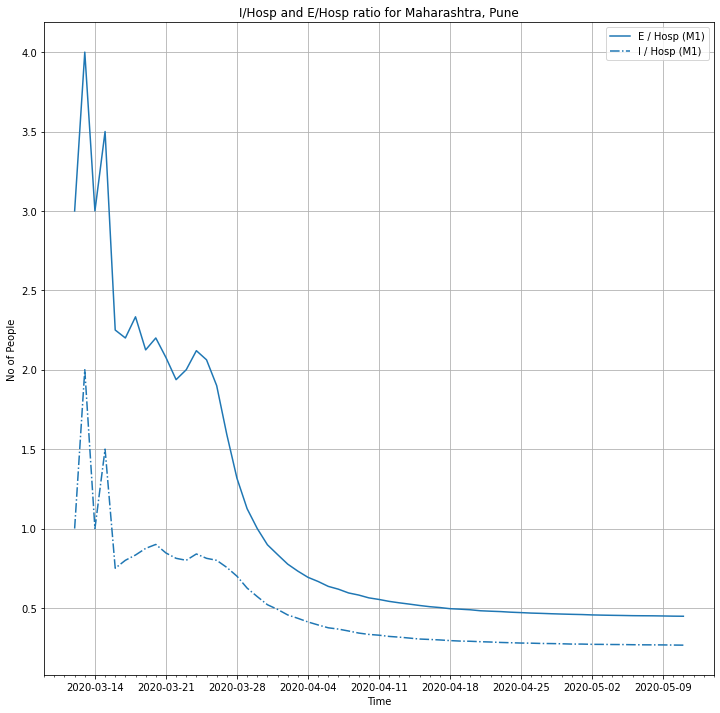

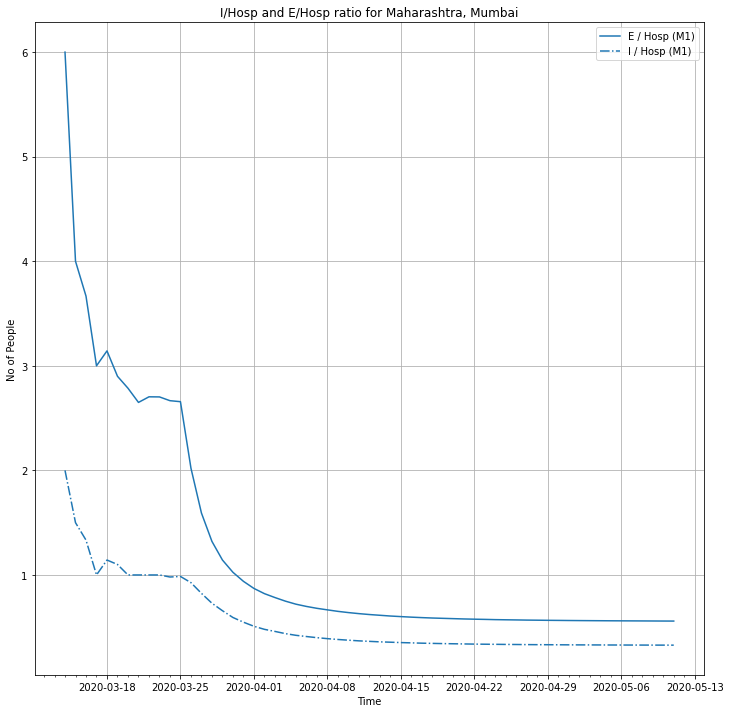

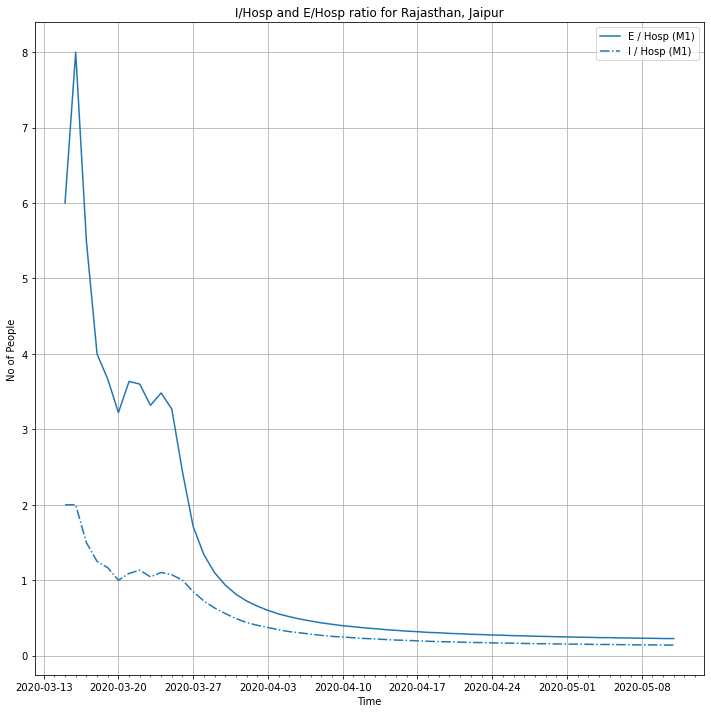

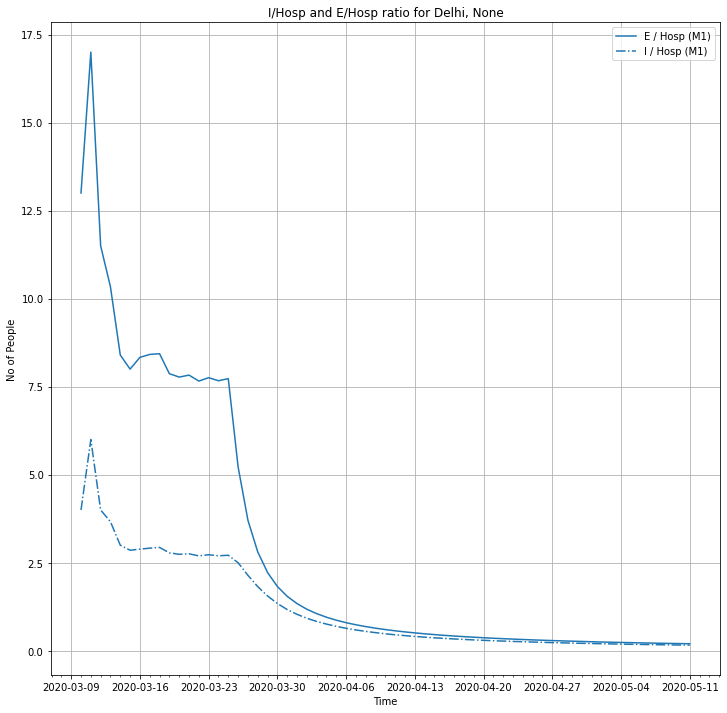

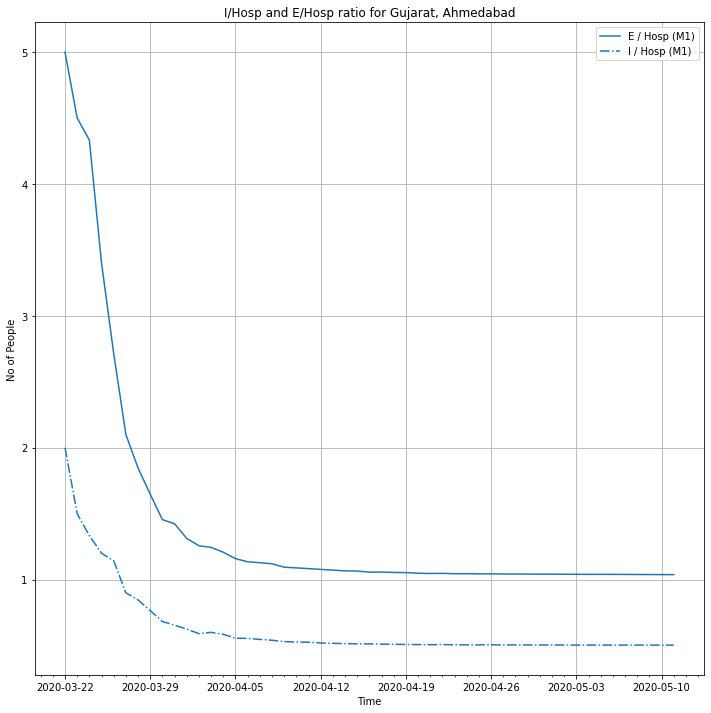

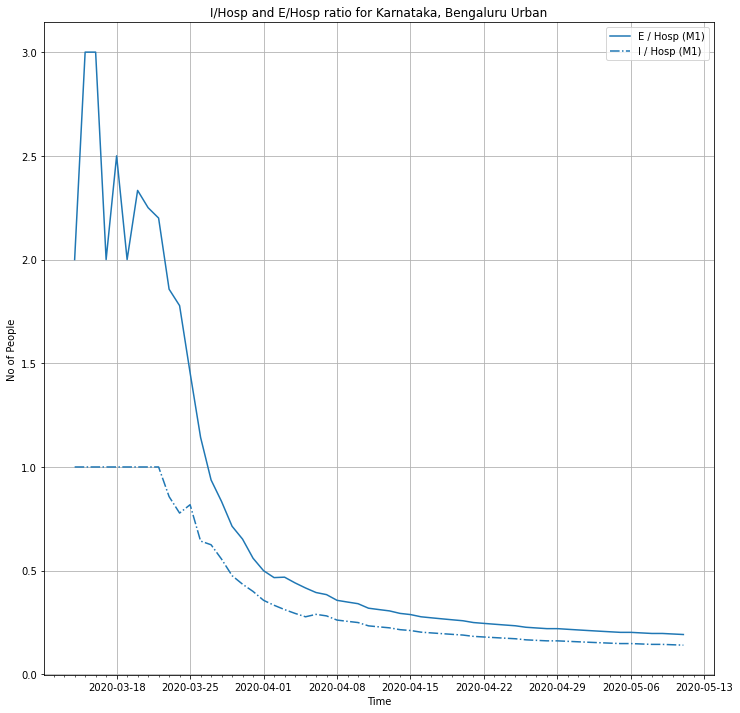

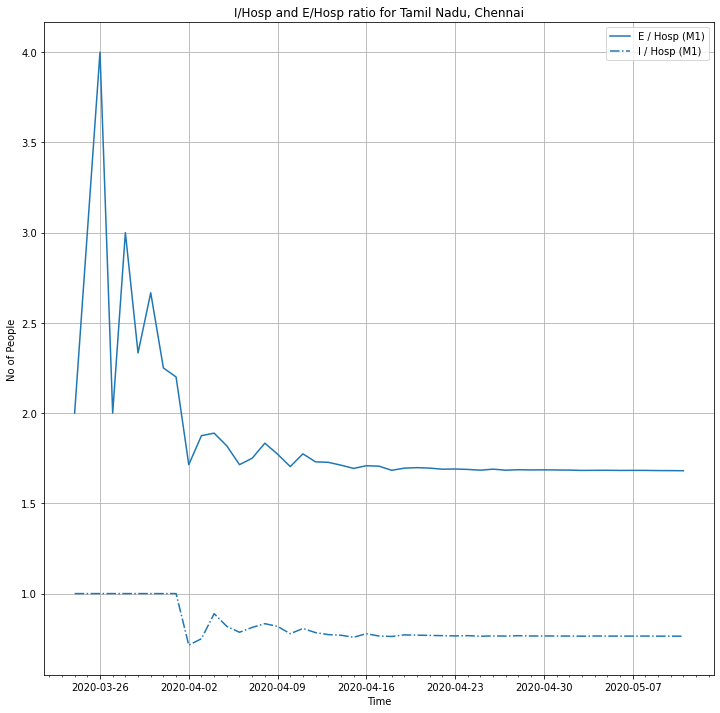

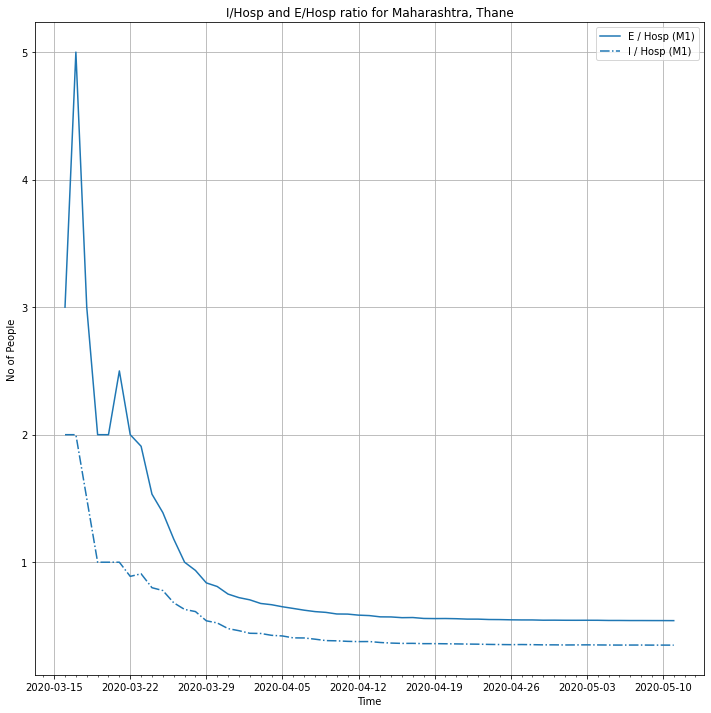

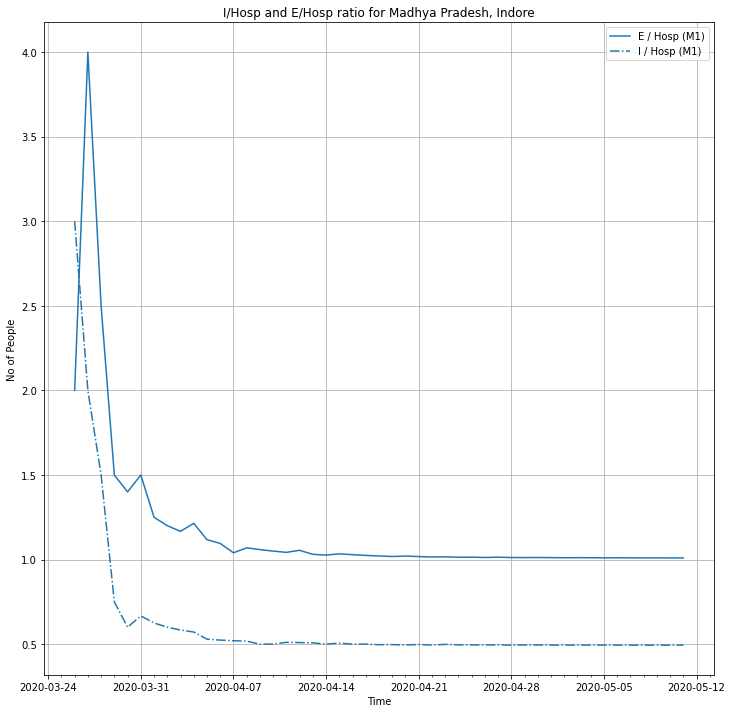

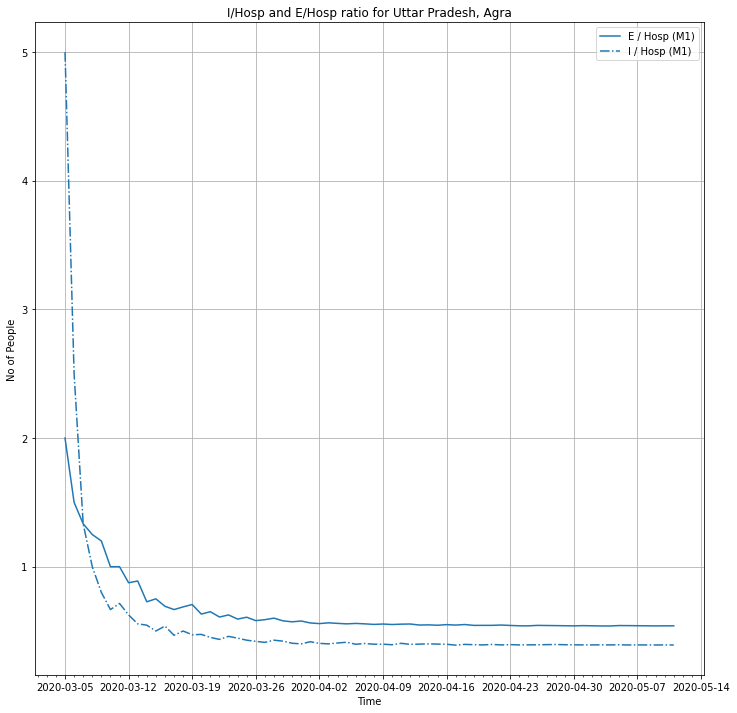

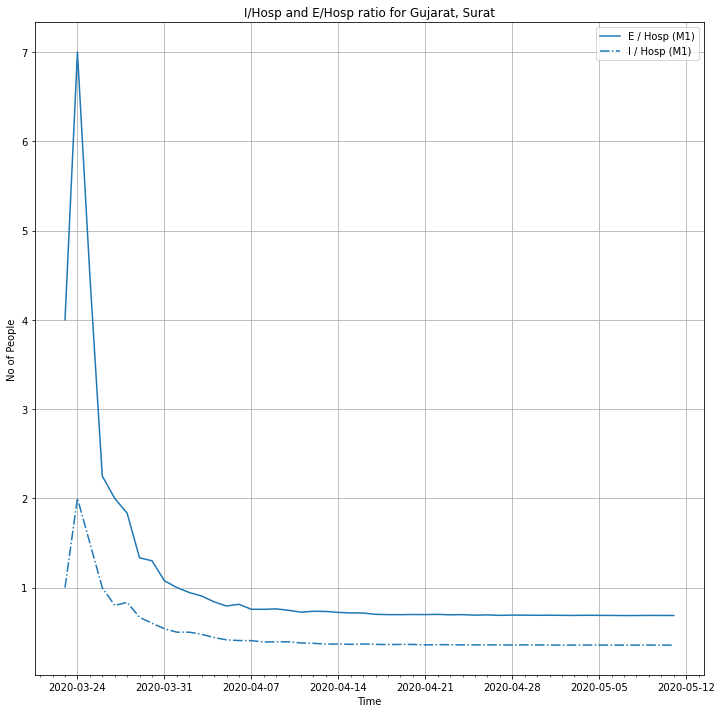

In [171]:
for district in predictions_dict.keys():
    district_dict = predictions_dict[district]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['E'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-', color='C0', label='E / Hosp (M1)')
    ax.plot(district_dict['m1']['df_prediction']['date'], district_dict['m1']['df_prediction']['I'] / district_dict['m1']['df_prediction']['hospitalised'],
            '-.', color='C0', label='I / Hosp (M1)')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.ylabel('No of People')
    plt.xlabel('Time')
    plt.legend()
    plt.title('I/Hosp and E/Hosp ratio for {}, {}'.format(district[0], district[1]))
    plt.grid()
    plt.show()

## Load Covid19india Data

In [114]:
dataframes = get_covid19india_api_data()

In [115]:
predictions_dict = {}

## Select Districts to fit on

In [120]:
districts_to_show = [('Maharashtra', 'Pune'), 
                     ('Maharashtra', 'Mumbai'), 
                     ('Rajasthan', 'Jaipur'), 
                     ('Gujarat', 'Ahmedabad'), 
                     ('Karnataka', 'Bengaluru Urban'),
                     ('Delhi', None)]

## Perform M1 and M2 fits

fitting to data with "train_on_val" set to False ..


/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
6   Maharashtra     Pune 2020-05-02         933.4          1325.4     100.2   
7   Maharashtra     Pune 2020-05-03        1054.6          1488.2     106.4   
8   Maharashtra     Pune 2020-05-04        1161.8          1656.0     111.0   
9   Maharashtra     Pune 2020-05-05        1253.8          1814.0     116.4   
10  Maharashtra     Pune 2020-05-06        1337.2          1970.2     123.0   

    recovered  
6       291.8  
7       327.2  
8       383.2  
9       443.8  
10      510.0  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra     Pune 2020-05-07       1416.2           2136    131.6   
1  Maharashtra     Pune 2020-05-08       1471.4         2259.4    138.8   
2  Maharashtra     Pune 2020-05-09         1493         2399.8      146   
3  Maharashtra     Pune 2020-05-10       1532.6         2561.4      153   
4  Mah

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date hospitalised total_infected deceased  \
13  Maharashtra     Pune 2020-05-09         1493         2399.8      146   
14  Maharashtra     Pune 2020-05-10       1532.6         2561.4      153   
15  Maharashtra     Pune 2020-05-11       1625.8         2758.2      158   
16  Maharashtra     Pune 2020-05-12         1610           2937      164   
17  Maharashtra     Pune 2020-05-13         1834           3161      164   

   recovered  
13     760.8  
14     875.8  
15     974.4  
16      1163  
17      1163  
val
 None
100%|██████████| 1500/1500 [01:26<00:00, 17.29trial/s, best loss: 2.3658780797558308]
best parameters
 {'E_hosp_ratio': 0.1258428978113228, 'I_hosp_ratio': 0.9995382335608607, 'P_fatal': 0.005557290068407099, 'P_severe': 0.30923454116256965, 'R0': 3.2529307516165735, 'T_inc': 4.7171789974841705, 'T_inf': 3.712937937095649, 'T_recov_severe': 15.290924428732286, 'intervention_amount': 0.880622105428

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date  hospitalised  total_infected  deceased  \
6   Maharashtra   Mumbai 2020-05-02        6541.8          8016.2     318.8   
7   Maharashtra   Mumbai 2020-05-03        7038.6          8593.0     338.2   
8   Maharashtra   Mumbai 2020-05-04        7643.4          9323.6     361.4   
9   Maharashtra   Mumbai 2020-05-05        8115.6          9930.6     384.2   
10  Maharashtra   Mumbai 2020-05-06        8647.6         10599.0     408.0   

    recovered  
6      1155.6  
7      1216.2  
8      1318.8  
9      1430.8  
10     1543.4  
val
          state district       date hospitalised total_infected deceased  \
0  Maharashtra   Mumbai 2020-05-07       9303.8        11411.8    437.2   
1  Maharashtra   Mumbai 2020-05-08         9944        12170.6    461.4   
2  Maharashtra   Mumbai 2020-05-09        10530          12932    484.6   
3  Maharashtra   Mumbai 2020-05-10      11052.8        13642.6    508.6   
4  Mah

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
           state district       date hospitalised total_infected deceased  \
13  Maharashtra   Mumbai 2020-05-09        10530          12932    484.6   
14  Maharashtra   Mumbai 2020-05-10      11052.8        13642.6    508.6   
15  Maharashtra   Mumbai 2020-05-11        11611        14363.6    527.4   
16  Maharashtra   Mumbai 2020-05-12        11878          14947      556   
17  Maharashtra   Mumbai 2020-05-13        12678          15747      556   

   recovered  
13    1917.4  
14    2081.2  
15    2225.2  
16      2513  
17      2513  
val
 None
100%|██████████| 1500/1500 [01:17<00:00, 19.35trial/s, best loss: 4.344302476918493]
best parameters
 {'E_hosp_ratio': 0.2031832358265066, 'I_hosp_ratio': 0.40108699642624085, 'P_fatal': 0.24047767740509798, 'P_severe': 0.7513341374012786, 'R0': 3.151871436177716, 'T_inc': 4.15538141840747, 'T_inf': 3.6383094878427524, 'T_recov_severe': 16.11743359956011, 'intervention_amount': 0.44927304849747973

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state district       date  hospitalised  total_infected  deceased  \
6   Rajasthan   Jaipur 2020-05-02         548.8           962.2      37.6   
7   Rajasthan   Jaipur 2020-05-03         548.2           990.2      41.2   
8   Rajasthan   Jaipur 2020-05-04         526.4          1022.6      44.6   
9   Rajasthan   Jaipur 2020-05-05         490.4          1052.6      47.6   
10  Rajasthan   Jaipur 2020-05-06         454.0          1083.0      50.4   

    recovered  
6       375.8  
7       400.8  
8       451.6  
9       514.6  
10      578.6  
val
        state district       date hospitalised total_infected deceased  \
0  Rajasthan   Jaipur 2020-05-07        421.2         1117.8     52.8   
1  Rajasthan   Jaipur 2020-05-08          389         1152.2     54.2   
2  Rajasthan   Jaipur 2020-05-09          381         1183.6     55.8   
3  Rajasthan   Jaipur 2020-05-10        383.8         1217.6     57.2   
4  Rajasthan   Jaipur 2020-0

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state district       date hospitalised total_infected deceased  \
13  Rajasthan   Jaipur 2020-05-09          381         1183.6     55.8   
14  Rajasthan   Jaipur 2020-05-10        383.8         1217.6     57.2   
15  Rajasthan   Jaipur 2020-05-11        399.6           1257     58.8   
16  Rajasthan   Jaipur 2020-05-12          395           1281       60   
17  Rajasthan   Jaipur 2020-05-13          450           1342       62   

   recovered  
13     746.8  
14     776.6  
15     798.6  
16       826  
17       830  
val
 None
100%|██████████| 1500/1500 [01:25<00:00, 17.46trial/s, best loss: 8.255009378179624]
best parameters
 {'E_hosp_ratio': 1.3091928666742876, 'I_hosp_ratio': 0.014431500260438317, 'P_fatal': 2.4288066268612907e-05, 'P_severe': 0.30894345748882207, 'R0': 4.23998595798636, 'T_inc': 4.496608058078085, 'T_inf': 3.9043485178557518, 'T_recov_severe': 11.166079884830284, 'intervention_amount': 0.8796556895587401}
fitti

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
       state   district       date  hospitalised  total_infected  deceased  \
6   Gujarat  Ahmedabad 2020-05-02        2896.8          3551.0     188.2   
7   Gujarat  Ahmedabad 2020-05-03        3074.2          3830.8     213.0   
8   Gujarat  Ahmedabad 2020-05-04        3256.4          4115.4     239.6   
9   Gujarat  Ahmedabad 2020-05-05        3434.0          4405.0     266.8   
10  Gujarat  Ahmedabad 2020-05-06        3602.0          4693.6     293.8   

    recovered  
6       466.0  
7       543.6  
8       619.4  
9       704.2  
10      797.8  
val
      state   district       date hospitalised total_infected deceased  \
0  Gujarat  Ahmedabad 2020-05-07       3771.6         4986.4    319.6   
1  Gujarat  Ahmedabad 2020-05-08       3894.8           5265    341.2   
2  Gujarat  Ahmedabad 2020-05-09       4007.6           5539    361.6   
3  Gujarat  Ahmedabad 2020-05-10       4062.4         5811.4    381.6   
4  Gujarat  Ahmedabad 2020-0

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
       state   district       date hospitalised total_infected deceased  \
13  Gujarat  Ahmedabad 2020-05-09       4007.6           5539    361.6   
14  Gujarat  Ahmedabad 2020-05-10       4062.4         5811.4    381.6   
15  Gujarat  Ahmedabad 2020-05-11       4096.6         6088.4    402.2   
16  Gujarat  Ahmedabad 2020-05-12         4058           6353      421   
17  Gujarat  Ahmedabad 2020-05-13         4087           6645      446   

   recovered  
13    1169.8  
14    1367.4  
15    1589.6  
16      1874  
17      2112  
val
 None
100%|██████████| 1500/1500 [01:25<00:00, 17.55trial/s, best loss: 0.47934883639988934]
best parameters
 {'E_hosp_ratio': 0.46339802681313624, 'I_hosp_ratio': 0.6905515005541798, 'P_fatal': 0.0664763597340261, 'P_severe': 0.3403348508470265, 'R0': 2.9870932744711878, 'T_inc': 4.185022016896323, 'T_inf': 3.8391484109637326, 'T_recov_severe': 17.21532471203219, 'intervention_amount': 0.018029566096742347}
fittin

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state         district       date  hospitalised  total_infected  \
6   Karnataka  Bengaluru Urban 2020-05-02          70.6           146.8   
7   Karnataka  Bengaluru Urban 2020-05-03          69.2           148.4   
8   Karnataka  Bengaluru Urban 2020-05-04          69.8           150.4   
9   Karnataka  Bengaluru Urban 2020-05-05          70.8           152.6   
10  Karnataka  Bengaluru Urban 2020-05-06          71.2           155.4   

    deceased  recovered  
6        5.6       70.0  
7        5.8       72.6  
8        6.0       73.6  
9        6.0       74.8  
10       6.0       77.2  
val
        state         district       date hospitalised total_infected deceased  \
0  Karnataka  Bengaluru Urban 2020-05-07           74          160.4        6   
1  Karnataka  Bengaluru Urban 2020-05-08         76.4          165.2      6.2   
2  Karnataka  Bengaluru Urban 2020-05-09         77.6          169.8      6.4   
3  Karnataka  Bengalu

/home/users/sansiddh/anaconda3/envs/covid/lib/python3.8/site-packages/pandas/core/indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


splitting data ..
splitting data ..
train
         state         district       date hospitalised total_infected  \
13  Karnataka  Bengaluru Urban 2020-05-09         77.6          169.8   
14  Karnataka  Bengaluru Urban 2020-05-10         79.8            175   
15  Karnataka  Bengaluru Urban 2020-05-11         81.6          179.2   
16  Karnataka  Bengaluru Urban 2020-05-12           83            182   
17  Karnataka  Bengaluru Urban 2020-05-13           81            184   

   deceased recovered  
13      6.4      84.8  
14      6.6      87.6  
15      6.8      89.8  
16        7        91  
17        7        95  
val
 None
100%|██████████| 1500/1500 [01:24<00:00, 17.72trial/s, best loss: 1.4158704418122212]
best parameters
 {'E_hosp_ratio': 0.14521573302195667, 'I_hosp_ratio': 0.41043791901004084, 'P_fatal': 0.026481848396353803, 'P_severe': 0.8738780347354053, 'R0': 2.8464842319783097, 'T_inc': 4.382738204224156, 'T_inf': 3.8842013050419757, 'T_recov_severe': 11.58373091877989, '

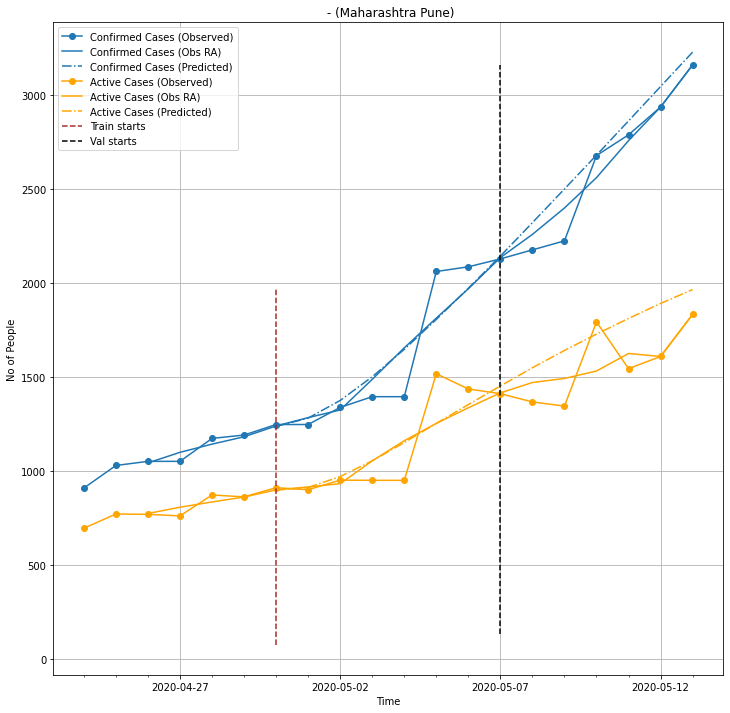

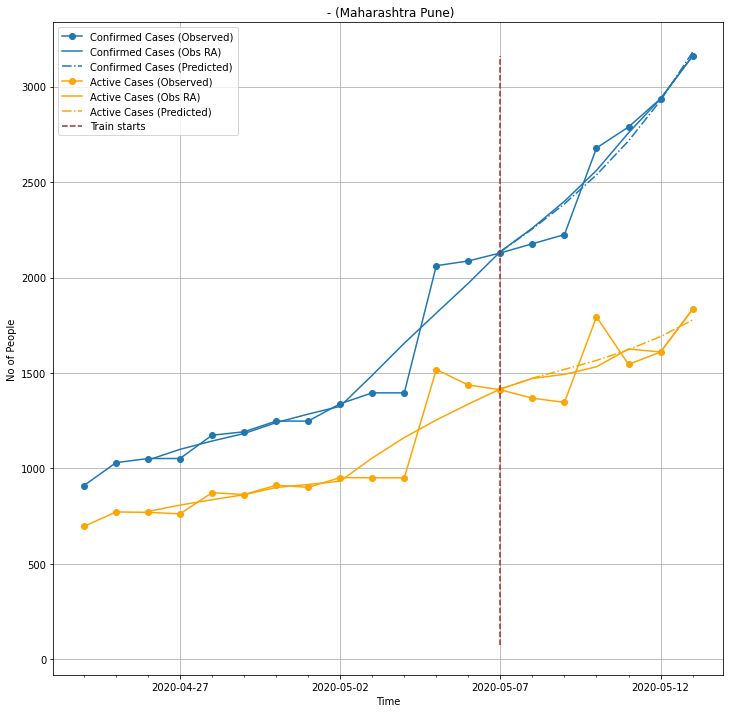

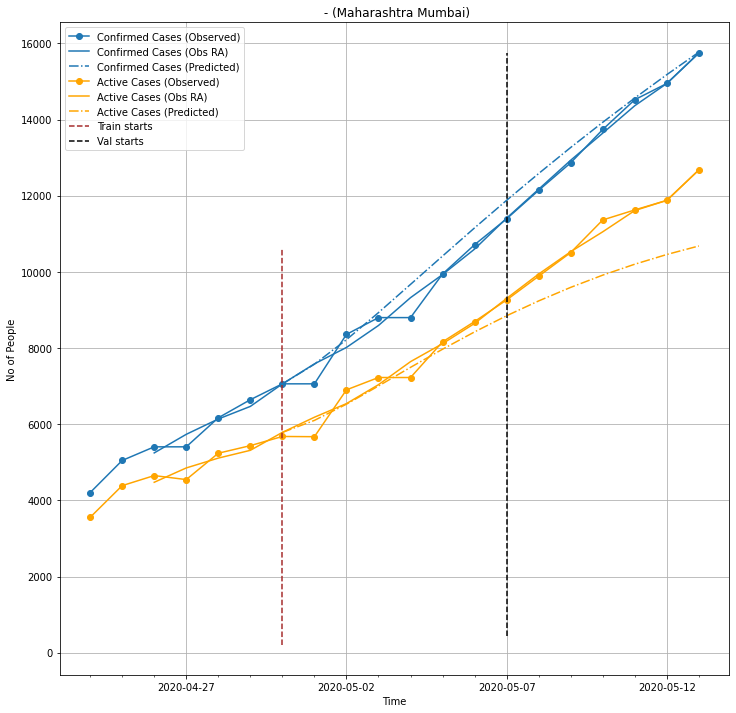

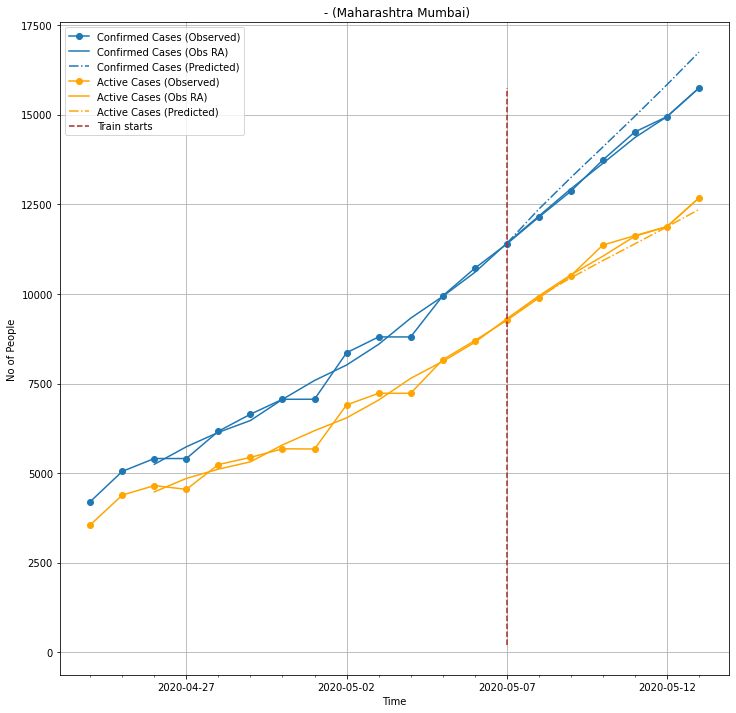

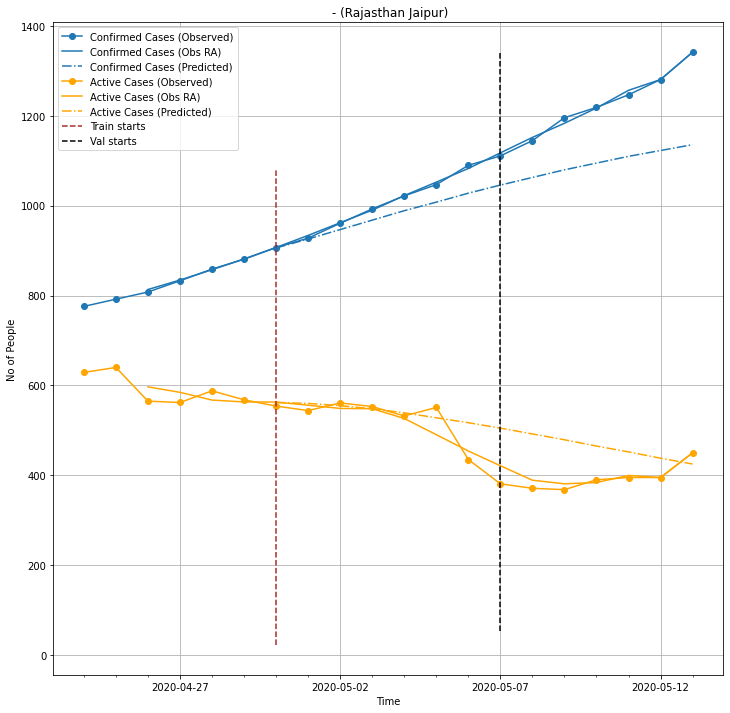

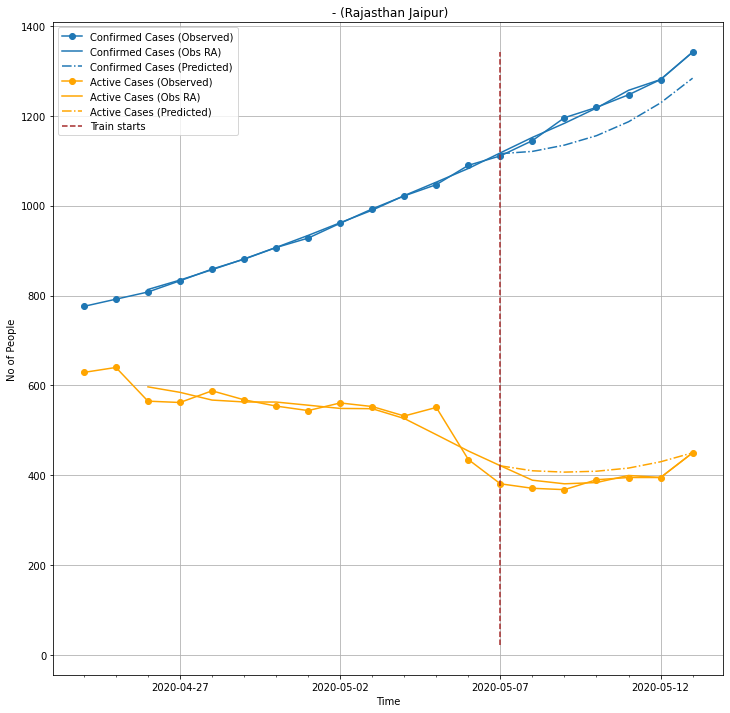

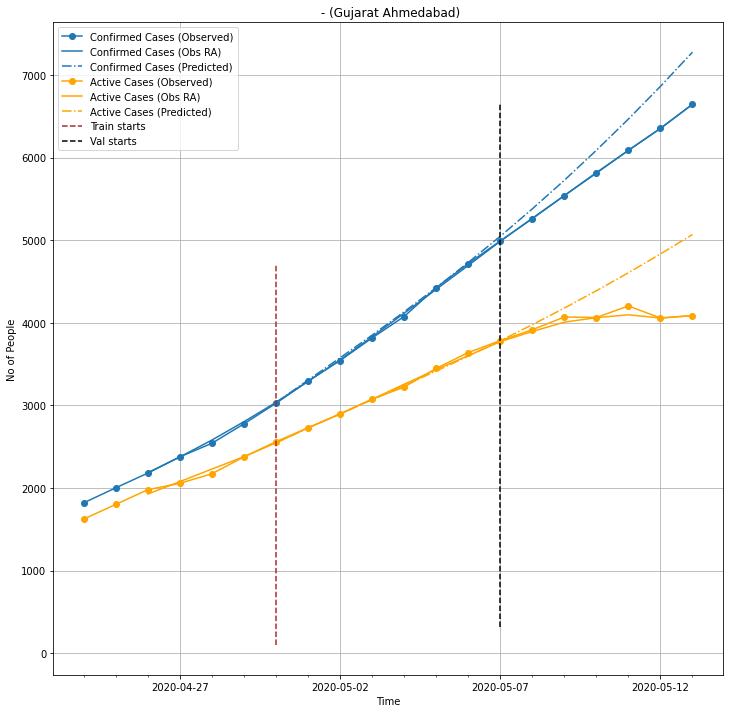

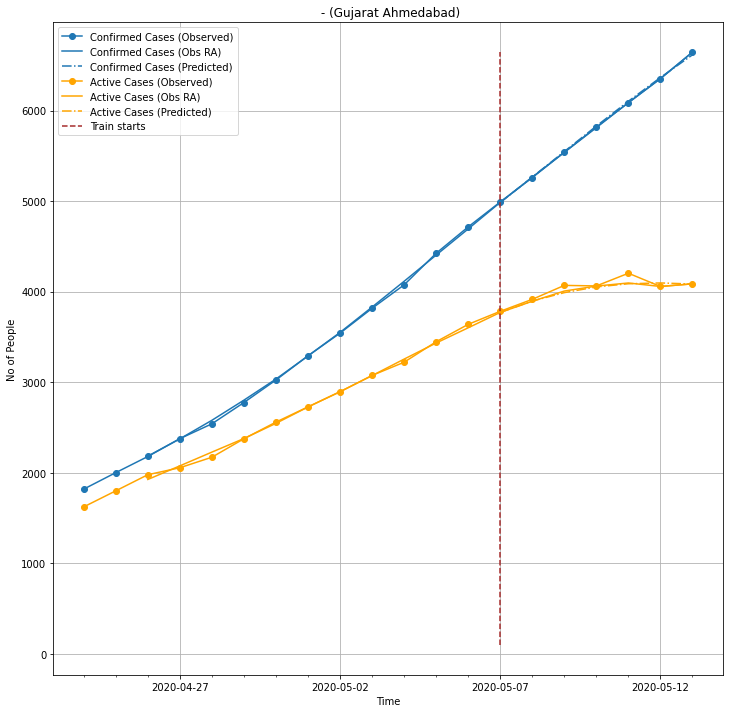

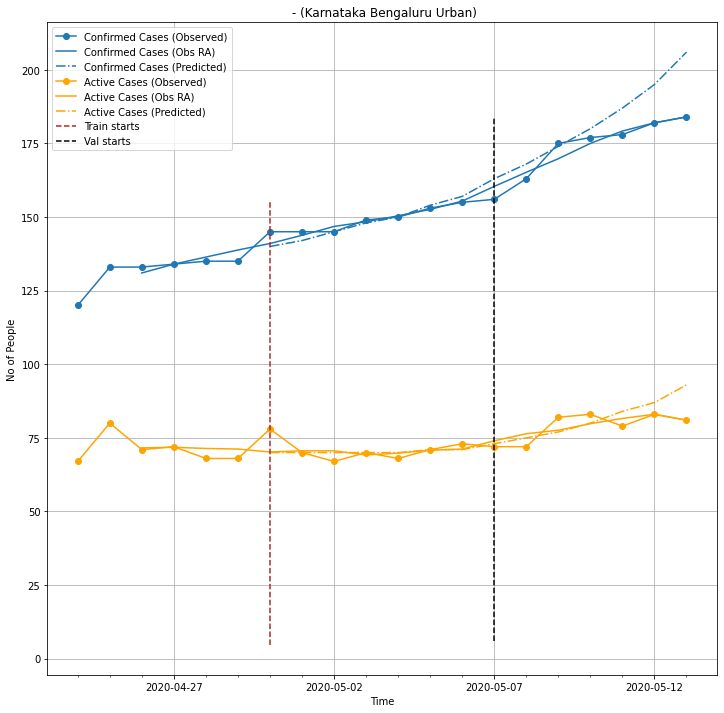

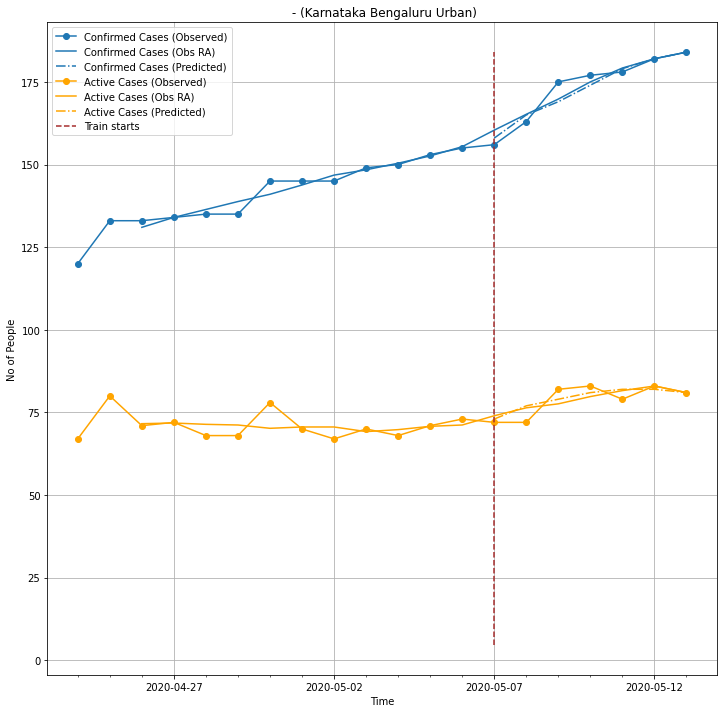

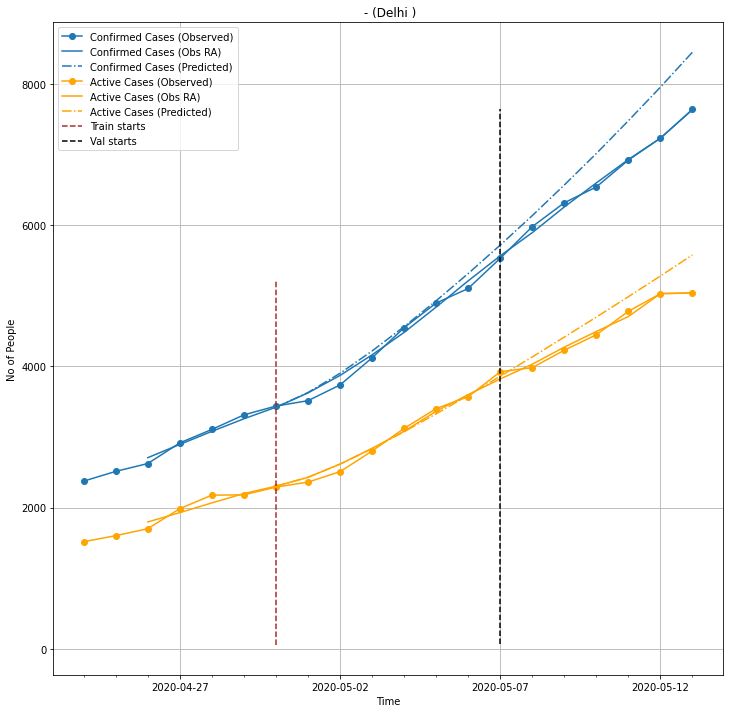

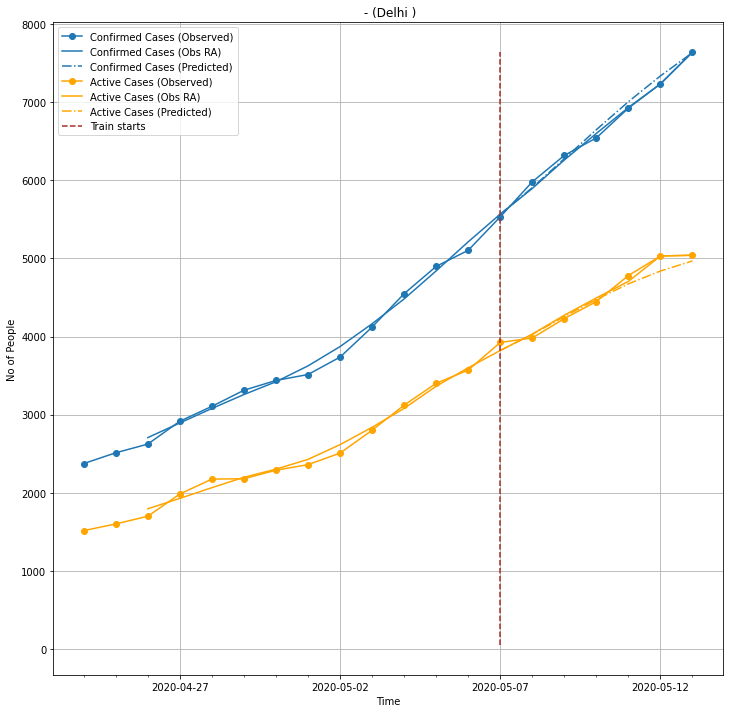

In [116]:
for state, district in districts_to_show:
    predictions_dict[(state, district)] = {}
    predictions_dict[(state, district)]['m1'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=7, 
                                                                     data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])
    predictions_dict[(state, district)]['m2'] = single_fitting_cycle(dataframes, state, district, train_period=7, val_period=0, 
                                                                     train_on_val=True, data_from_tracker=True, initialisation='intermediate',
                                                                     which_compartments=['hospitalised', 'total_infected'])

## Create Master Loss Dataframe

In [117]:
loss_columns = pd.MultiIndex.from_product([predictions_dict[('Maharashtra', 'Pune')]['m1']['df_loss'].columns, predictions_dict[('Maharashtra', 'Pune')]['m1']['df_loss'].index])
loss_index = predictions_dict.keys()

df_loss_master = pd.DataFrame(columns=loss_columns, index=loss_index)
for key in predictions_dict.keys():
    df_loss_master.loc[key, :] = np.around(predictions_dict[key]['m1']['df_loss'].values.T.flatten().astype('float'), decimals=2)
    
df_loss_master

train                         val  \
                            hospitalised total_infected hospitalised   
Maharashtra Pune                    8.46           6.91        10.39   
            Mumbai                  3.86           3.93        11.73   
Rajasthan   Jaipur                  3.97           2.52        16.68   
Gujarat     Ahmedabad               0.52           0.59         7.95   
Karnataka   Bengaluru Urban         3.06           1.18         5.58   
Delhi       NaN                     1.84           2.18         4.77   

                                            
                            total_infected  
Maharashtra Pune                      3.76  
            Mumbai                       2  
Rajasthan   Jaipur                   11.51  
Gujarat     Ahmedabad                 4.71  
Karnataka   Bengaluru Urban           4.52  
Delhi       NaN                       6.08

## Plot Forecasts

getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..
getting forecasts ..


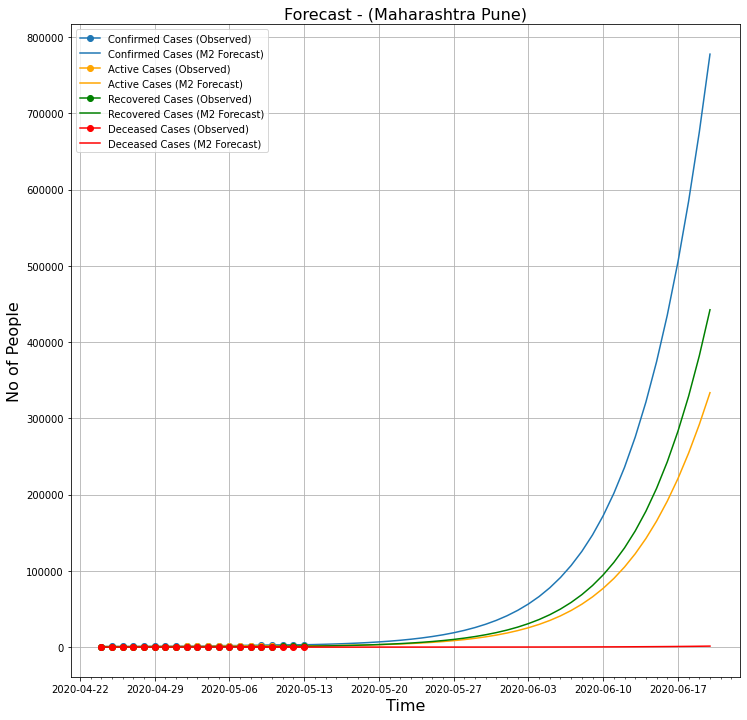

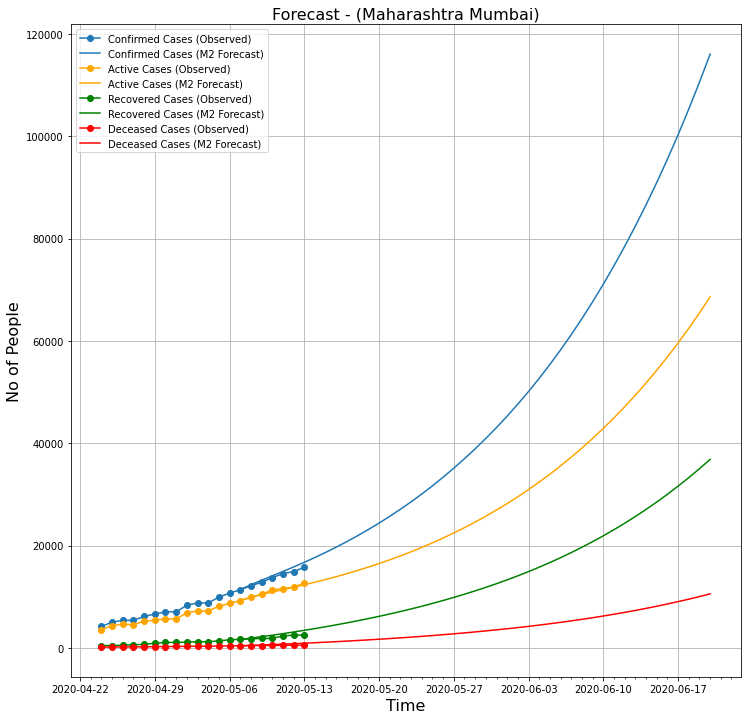

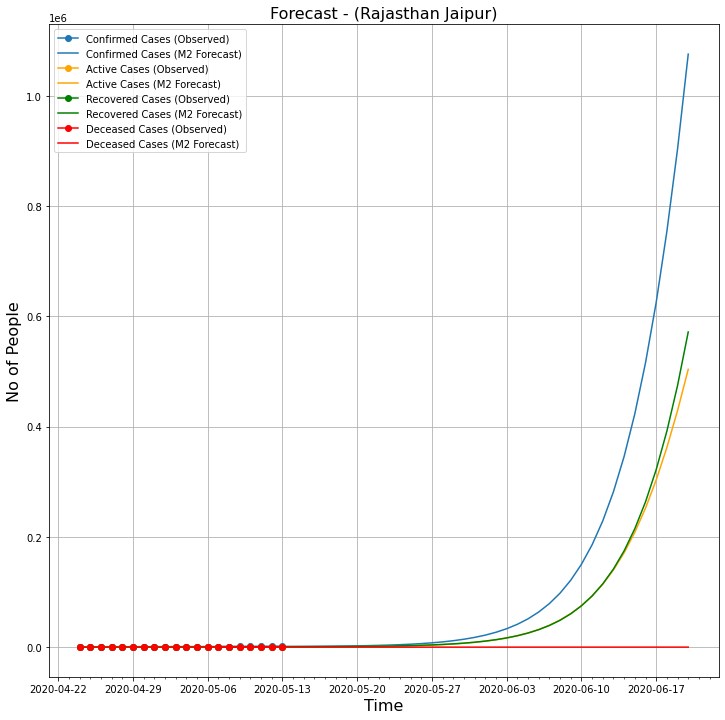

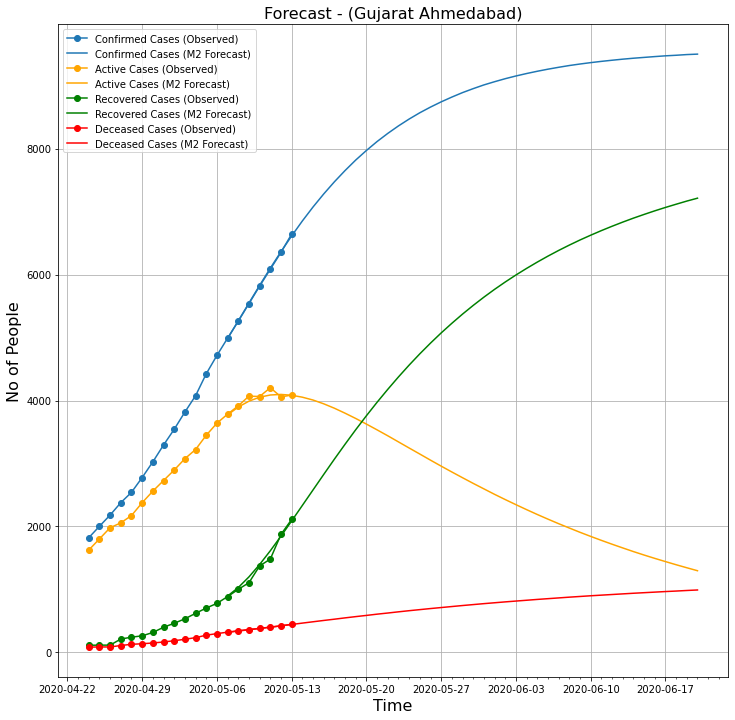

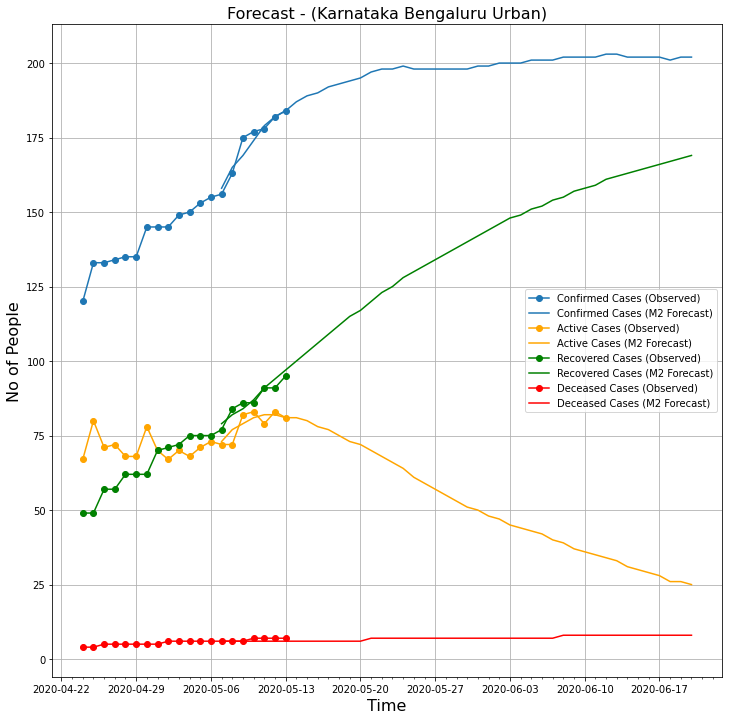

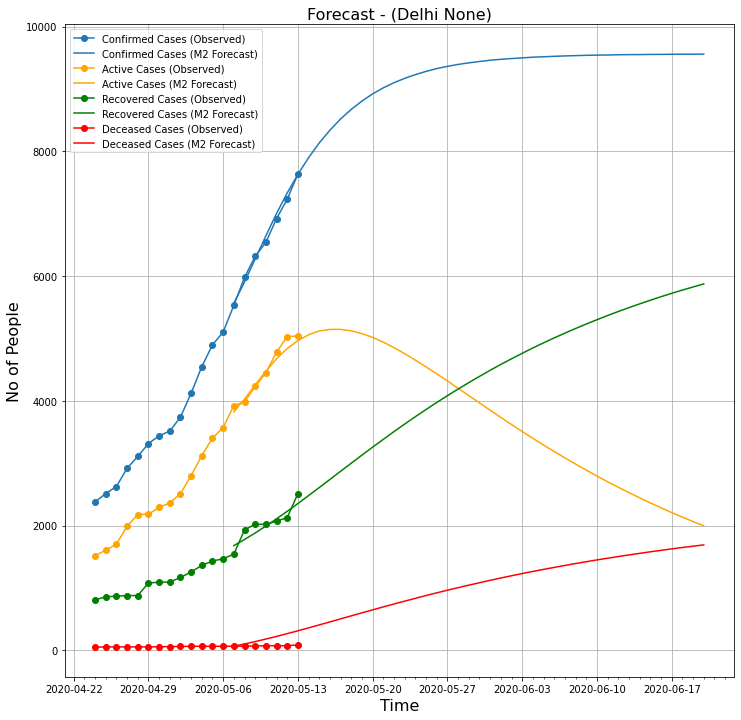

In [119]:
for region in predictions_dict.keys():
    plot_forecast(predictions_dict[region], region, both_forecasts=False)

## Create and Save Output CSV

In [85]:
df_output = create_all_csvs(predictions_dict, initialisation='intermediate', train_period=7, icu_fraction=0.02)

compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..
compiling csv data ..
getting forecasts ..


In [88]:
write_csv(df_output, '../../output-{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

## Custom Pune Plotting

getting forecasts ..


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


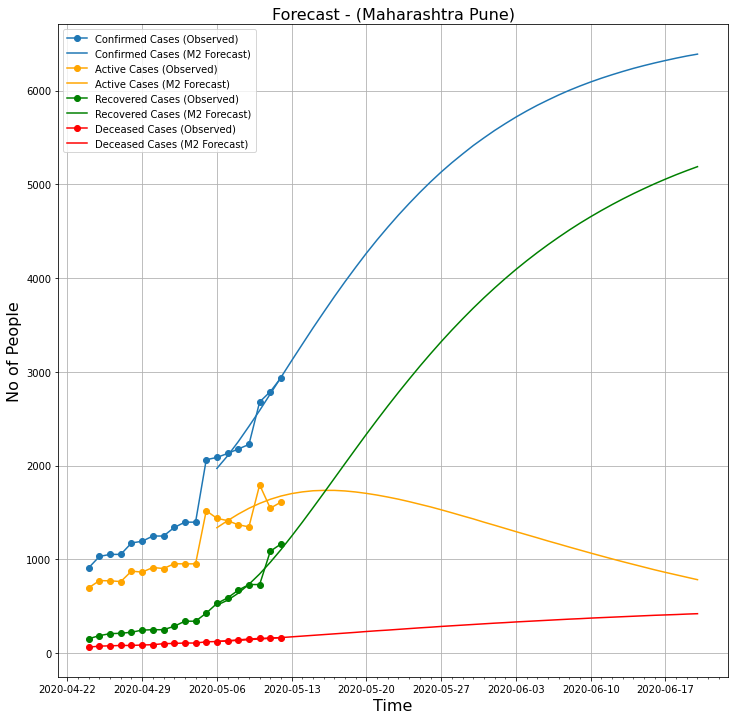

In [110]:
plot_forecast(predictions_dict[('Maharashtra', 'Pune')], ('Maharashtra', 'Pune'), both_forecasts=False, filename='../../plots/m2-only.eps')